# Setup

## Colab setup

Run the following cells in order (by pressing `Shift-Enter` or clicking on the "play" button at the top-left of a cell when mousing over it). When a warning pops up, choose "Run anyway".

In [ ]:
!rm -r sample_data
!git clone https://github.com/SimoneBarbaro/data_science_lab_project.git

In [ ]:
import os
os.chdir("./data_science_lab_project/data")
!wget -O rare_targets.csv https://polybox.ethz.ch/index.php/s/Cde1r0DYLl8EX1B/download
os.chdir("..")

### Importing the results
You may choose from the following two methods how you wish to import the results into the notebook.

**Google Drive**:
- requires the use of a (personal) Google account

**Polybox**:
- public link exposes the results archive for a few minutes (if someone were to guess the link in that time)

#### Google Drive instructions
1. _(Required only once per results archive.)_ In your [Google Drive](https://drive.google.com), create a folder called "Colab Notebooks" and upload the results archive `results_2020_12_31.zip` ([Polybox link](https://polybox.ethz.ch/index.php/f/2201908333)) into it.
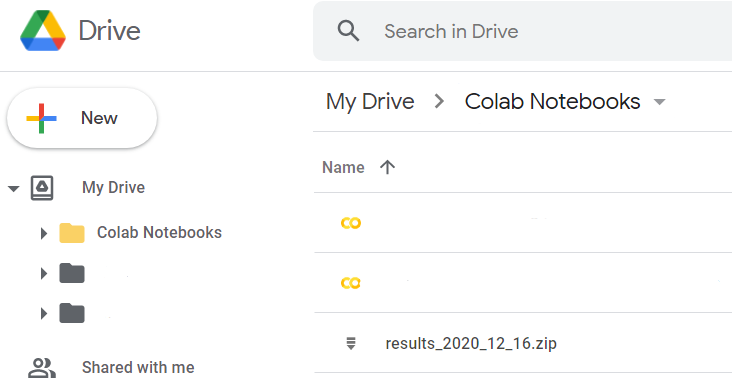
2. Run the following cell and follow the instructions to link your Drive to the notebook:

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

3. The following cell will copy the results archive into the current instance of the notebook:

In [ ]:
!cp "/content/drive/MyDrive/Colab Notebooks/results_2020_12_31.zip" ./

4. You may now skip ahead to [After importing the results](#after-results-import).

#### Polybox instructions
1. _(Required only once per results archive.)_ Reupload the results archive `results_2020_12_31.zip` ([Polybox link](https://polybox.ethz.ch/index.php/f/2201908333)) to your [Polybox](https://polybox.ethz.ch).
2. Open the file details of the results archive in Polybox, choose the "Public Links" tab, and create a (passwordless) public link.
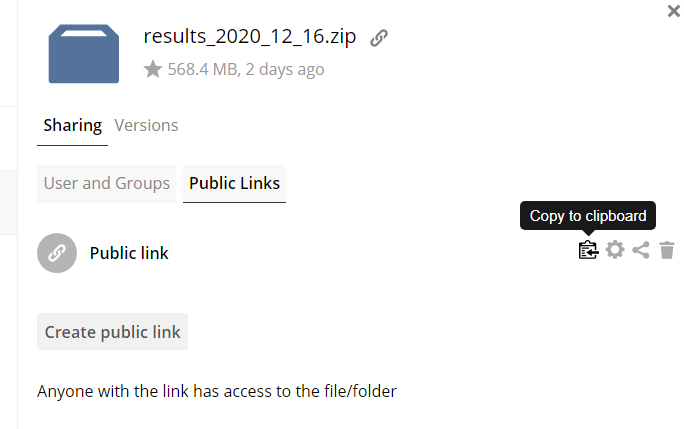
3. Copy the link to the clipboard at paste it in the cell below replacing the example link within the quotes, then run the cell.

In [ ]:
%%bash
LINK="https://polybox.ethz.ch/index.php/s/ExAmPlE0eXaMpLe"
wget -O results_2020_12_31.zip $LINK/download

4. When the download finishes, delete the public link in Polybox using the trash can icon.

<a id='after-results-import' name='after-results-import'></a>
#### After importing the results either via Google Drive or Polybox:

In [ ]:
!unzip results_*.zip

In [ ]:
!pip install -r requirements.txt
os.chdir("src")

Read the available results from the file system: 

In [ ]:
import os, json, re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
cwd = os.getcwd()
results_directory = "../results"
results_directory = os.path.join(cwd, results_directory)
results_table = []
for f in os.listdir(results_directory):
    path = os.path.join(results_directory, f)
    if os.path.isdir(path):
        info_data = os.path.join(path, "results_info.json")
        if os.path.exists(info_data):
            with open(info_data) as info_f:
                info = json.load(info_f)
            results_table.append({"folder": f,
                                  "dataset": info["dataset"],
                                  "method": re.search("_(.*?)[0-9]", f).group(1),
                                  "clusters": re.search("([0-9]+)", f).group(1),
                                  "normalization": "norm" if re.search("norm", f) else "",
                                  "aggl_ave": "ave" if re.search("ave", f) else "",
                                  "silhouette": info["silhouette_score"]})
        else:
            results_table.append({"folder": f})
results_table = pd.DataFrame(results_table)

def full(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_seq_items', None, 'display.max_colwidth', None):
        display(df)

Running the following cell should now list the runs that can be analyzed: each first specifies the dataset, then the clustering method, followed by the number of clusters and other relevant parameters.

The clustering methods are:
- `aggl`: [Agglomerative clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)
    - `ave` in agglomerative clustering refers to the parameter `linkage='average'` (as opposed to the default `linkage='ward'`)
- `kmeans`: [K-means clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
- `gmm`: [Gaussian mixture model](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)

`norm` refers to [normalization of columns to a standard normal distribution](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) prior to clustering.

[Silhouette scores](https://en.wikipedia.org/wiki/Silhouette_(clustering)) are also reported: a higher score (maximum 1) means the clusters are more coherent.

In [ ]:
sorting_column = "silhouette"
sort_increasing = False

full(results_table.sort_values(sorting_column, ascending=sort_increasing))
# Note the use of the "full" function above: in case a table is not displayed in full
# (rows, columns or text hidden), you may wrap it into "full(...)" to show it in full.

## Choose one of the clustering methods from the "folder" column above

In [ ]:
name_analysis = 'spider_aggl5avenorm'

In [ ]:
# The following sets up filepath variables for use later in the notebook
result_path = os.path.join(results_directory, name_analysis)
analysis_path = os.path.join(result_path, "analysis")

# Clusters

Show the beginning of the clustering results file to check it was read correctly:

In [ ]:
pth = os.path.join(result_path, 'results.csv')
clustering_results = pd.read_csv(pth)
display(clustering_results.head())
print("Number of drug pairs: {}\nNumber of clusters: {} (from {} to {})".format(clustering_results.shape[0], clustering_results["cluster"].drop_duplicates().count(), clustering_results["cluster"].min(), clustering_results["cluster"].max()))

Query for a specific drug pair provide names of both drugs in cell below:

In [ ]:
name1 = 'tamoxifen'
name2 = 'bupropion'
clustering_results[(clustering_results['name1'] == name1) & (clustering_results['name2'] == name2)]

# Side effects analysis

## Choose a level of side effects

There are five levels to the MedDRA hierarchy, of which four are available here. `System Organ Classes (SOC)` are the highest level terms based on location, etiology, or purpose. `High Level Group Terms (hlgt)` which are the next highest level terms are groups of `High Level Terms (hlt)` grouped together by anatomy, pathology, physiology, etiology and function. Likewise, `High Level Terms (hlt)`s themselves are groups of `Preferred Terms (pt)`, the most specific terms, grouped together by the same criteria.

In the cell below, choose the analysis level of Meddra terms to look at for the analysis.

In [ ]:
analysis_level = 'soc'

In [ ]:
pth = os.path.join(analysis_path, 'scores_' + analysis_level + '_term.csv')
sideeffect_results = pd.read_csv(pth)
sideeffect_results

Show the top `N` side effects per group:

In [ ]:
N = 4

full(sideeffect_results.sort_values(["cluster","rank"]).groupby("cluster").head(N).set_index(["cluster", "{}_term".format(analysis_level)]))

## Clusters numbers

Show cluster labels and count them:

In [ ]:
sideeffect_results["cluster"].drop_duplicates().values

In [ ]:
num_clusters = sideeffect_results["cluster"].drop_duplicates().count()
num_clusters

## Choose a specific cluster to inspect

Below, one can choose which specific cluster to look at and analyze the significant side effects by changing the `cluster_no` variable.

In [ ]:
cluster_no = 0

In [ ]:
sideeffect_results[sideeffect_results['cluster'] == cluster_no].sort_values("rank")

# Significance Analysis

The significance analysis shows which side effects are shown to be significant in each cluster using the [Grubbs test](https://en.wikipedia.org/wiki/Grubbs%27s_test#One-sided_case) at a significance level of 0.005. Below, choose a level of MedDRA hierarchy to observe the significant side effects predicted in each cluster. <!-- The `alpha` value determines the statistical significance level for which effects are significant. Currently only results for `alpha = 0.005` are computed. // alpha = 0.005  # Currently only 0.005 is available, do not change -->

## Choose a level of side effects

In [ ]:
analysis_level = 'soc'

In [ ]:
pth = os.path.join(analysis_path, 'significant_' + analysis_level + '_ranks_' + str(0.005) + '.csv')
statistical_results = pd.read_csv(pth)
full(statistical_results)

Look at a given side effect term for all clusters:

In [ ]:
term = "Pregnancy, puerperium and perinatal conditions"
sideeffect_results[(sideeffect_results.iloc[:,1] == term)].sort_values("tfidf_score", ascending=False)

Look at the significant results summary. Each row shows a drug pair, its cluster and the top `soc`, top 3 `hlgt`, top 3 `hlt` and top 3 `pt` side effects for that cluster. `NaN` means the cluster did not have a significant side effect at a given level.

In [ ]:
pth = os.path.join(analysis_path, 'significant_summary_ranks_' + str(0.005) + '.csv')
summary_results = pd.read_csv(pth)
summary_results

Query for specific drugs

In [ ]:
name1 = 'tamoxifen'
name2 = 'bupropion'
summary_results[(summary_results['name1'] == name1) & (summary_results['name2'] == name2)]

# Target distribution for significant clusters

This block will run the Interactive Analysis for identifying the strongest targets in each cluster.

In [ ]:
from experiment.interactive_analysis import InteractiveAnalyzer

In [ ]:
analyzer = InteractiveAnalyzer(result_path)

#### Choose the level, the number of clusters to consider and the number of targets per cluster to show

In [ ]:
analysis_level = 'hlgt'
targets_per_cluster = 15
cluster_number = num_clusters

In [ ]:
significant_clusters, important_targets = analyzer.get_important_data(analysis_level, cluster_number, targets_per_cluster)
significant_clusters

Return any clusters where an important target is from the pre-defined list of rare targets:

In [ ]:
analyzer.get_rare_important_targets(cluster_number, targets_per_cluster)

#### Choose a specific cluster to inspect, any number from 0 to the number of clusters
as well as a threshold value (between 0 and 2 for SPiDER) representing sufficient probability for a drug pair to interact with a target.

In [ ]:
cluster_no = 0
threshold = 0.5

Descriptive statistics of the distribution of scores for important target of the chosen cluster:

In [ ]:
important_targets = analyzer.get_important_targets(cluster_no, targets_per_cluster)
desc = important_targets.describe()
frac = (important_targets > threshold).sum()/(important_targets.count())
frac = frac.rename("Fraction above Threshold")
desc.append(frac)

#### Choose a target to visualize from the columns above
Remember that the target names depend on the dataset

In [ ]:
target = 's_target_95'

Histogram of the distribution of the scores of the given target within the chosen cluster:

In [ ]:
important_targets[target].plot.hist(xlim=([0,2] if "spider" in name_analysis else None))
plt.axvline(threshold, color='k', linewidth=2)
plt.text(threshold-0.055, plt.axis()[3]*0.2, 'threshold', rotation=90)